## Basic spec and description

We have a set of N agents. Let $p_{m1}$ be the proportion of committed minority disbelief agents, and let $p_{m2}$ be the proportion of committed minority belief agents. Then $1 - p_{m1} - p_{m2}$ is the proportion of majority agents. 

We define separate prior distributions for each sub-population of agents, which is uniform across the population in the beginning. Motivated by prior-posterior updating convenience, we consider conjugate families for Bayesian updating. We assume the distribution represents the probability that the agent, if polled would respond "yes" to a question of whether they or not they believe in the proposition. 

Some basic rules for interactions between agents: 
- beliefs don't update when majority agents interact
- minority beliefs don't update at all 
- belief updating is vaguely compositional/symmetric (interacting with a committed minority, then another committed minority of another type, should cancel out the first interaction) 

#### Bayesian Model: Beta-Bernoulli / Polya's Urn
We use a simple conjugate prior family, the beta-bernoulli family of distributions. The general update model is that the prior beta distribution represents a randomization of the parameter of the Bernoulli distribution.

The Beta-Bernoulli process also results in updates that are exchangeable, in that the updates can occur in different orders and would not change the distribution. 

The parameter of the beta distribution, $\theta$, would represent the probability of a yes-response of a Bernoulli trial. Here the Bernoulli trial represents the response of an agent, if polled about their beliefs about climate change. 

This model is a simple and analytically tractable Bayesian model. 

Beta distribution: parameterized by $\theta \in [0,1]$ and two hyperparameters $(a,b)$. 
\begin{align}
p(\theta; a, b) = \frac{1}{B(a,b)} \theta^{a - 1} (1-\theta)^{b-1}
\end{align}

\begin{equation}
E[X] = \frac{a}{a+b} 
\end{equation}

Each bayesian update from a Bernoulli trial updates the parameter a 1 if successful, and the parameter b by 1 if the update "failed". (If the updates are binomial, the hyperparameters are updated by number of successes or failures). Therefore we can think of updates as updating the probability parameter of a Bernoulli trial based on previous successes and failures: in this situation, we can think of adding "reasons" to believe or disbelieve in climate change based on interactions with committed minorities. It becomes difficult to change beliefs after multiple interactions, which we can potentially change by scaling the binomial distribution updates. 


u'C:\\Users\\paint_000\\Anaconda\\SED-ABM'

In [30]:
from scipy.special import gamma
from scipy.special import gammaln
from scipy.stats import beta 
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt 
import random

# 
%matplotlib inline

######################################################
# Simulation Parameters

n = 100
# committed believers
minority_n = int(0.16*n)
minority_theta_0 = 1 # 0 => always responds with positive belief
minority_ab = find_a_b(1,1,1)
# We need to fit hyperparameters: we want to choose a and b such that the 
# prior probability of theta being within some interval is some probability p. 
#print minority_ab

# committed disbelievers
minority_2_n = int(0.13*n)
minority_2_theta_0 = 0
minority_2_ab = find_a_b(0,0,1)
minority_2_ab.x = [0,1]
#print minority_2_ab

majority_theta_0 = 0.5
majority_ab = find_a_b(0.4, 0.6, 0.1)
print majority_ab.x
#print majority_ab
agents = np.arange(n)
np.random.shuffle(agents)



minority = agents[0:minority_n] 
minority_2 = agents[minority_n:(minority_n+minority_2_n)]
majority = agents[(minority_n+minority_2_n):n]

## Beliefs are arrays of theta, a, b
minority_beliefs = dict.fromkeys(minority, {'ab': minority_2_ab.x, 'theta': minority_theta_0, 'type': 'minority'})
minority_2_beliefs = dict.fromkeys(minority_2, { 'ab': minority_2_ab.x,  'theta':minority_2_theta_0, 'type': 'minority_2'})
majority_beliefs = dict.fromkeys(majority,  {'ab': majority_ab.x, 'theta': majority_theta_0, 'type': 'majority'} )

agent_beliefs = merge_dicts(minority_beliefs, minority_2_beliefs, majority_beliefs)


[ 0.86691122  1.12104273]


### Helper Functions

In [33]:
###### function find_a_b fits the hyperparameters for beta prior
###### "what values of a and b result in a theta prior being between 
###### theta_low, theta_high, with probability p? "
###### returns: [a, b]
# find_a_b(0.45,0.5,0.6)
def find_a_b(theta_low, theta_high, p): 
    optimal = optimize.minimize( lambda param: abs((beta.pdf(theta_low, param[0], param[1]) - beta.pdf(theta_high, param[0], param[1])) - p ), [1,1])
    # return an array of a, b
    return optimal

def merge_dicts(*dict_args):
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

# Helper function for pairwise belief updating 
# Update the beliefs of agent by the beliefs of agent 2
# Assuming beta-binomial 
def update_beliefs(agent, agent2, agent_beliefs, t):
    if (agent_beliefs[agent]['type'] == 'minority') or (agent_beliefs[agent]['type'] == 'minority_2'): 
        return
    # update beliefs depending on type of other agent
    elif agent_beliefs[agent2]['type'] == 'minority': 
        agent_beliefs[agent]['ab'][0] += 1
    elif agent_beliefs[agent2]['type'] == 'minority_2': 
        agent_beliefs[agent]['ab'][1] += 1.2
    # split the \sqrt(t) if updating by a majority agent
    # update: don't update if interacting w majority
#    else: 
#         agent_beliefs[agent]['ab'][0] += agent_beliefs[agent2]['theta'] 
#         agent_beliefs[agent]['ab'][1] += (1- agent_beliefs[agent2]['theta'])

    agent_beliefs[agent]['theta'] = 1.0 * agent_beliefs[agent]['ab'][0]/ (agent_beliefs[agent]['ab'][0] + agent_beliefs[agent]['ab'][1])
    return 
def update_belief_assignment(agent_dict): 
    minority_n = 0
    minority_2_n = 0 
    majority_n = 0 
    for agent in agent_dict: 
        if (agent_dict[agent]['theta'] > 0.8): 
            agent_dict[agent]['type'] == 'minority'
            minority_n += 1
        if (agent_dict[agent]['theta'] < 0.2): 
            agent_dict[agent]['type'] == 'minority_2'
            minority_2_n += 1
        else: 
            majority_n += 1
    return [minority_n, minority_2_n, majority_n]
            
#def mean_sd_type(agent_dict, type): 
    # return the mean and standard deviation of the hyperparameters of a certain type ? 
    # this is nT: can be made more efficient

# Main simulation loop

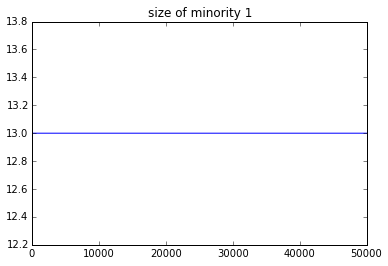

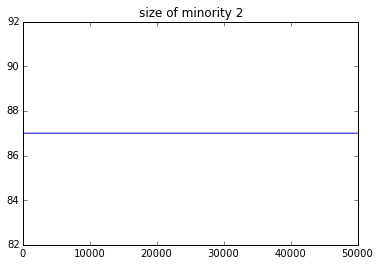

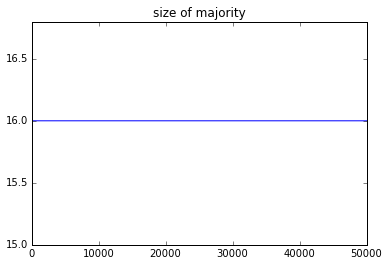

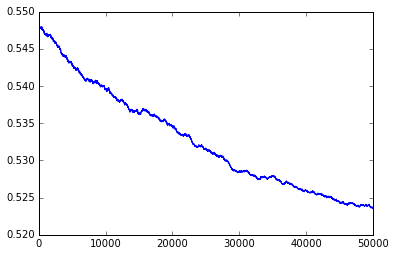

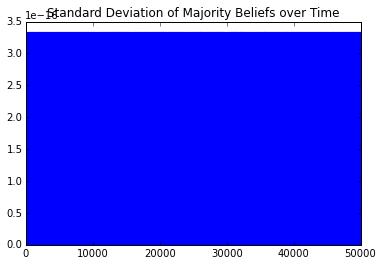

{0: {'theta': 1, 'ab': [0, 1], 'type': 'minority'}, 1: {'theta': 0, 'ab': [0, 1], 'type': 'minority_2'}, 2: {'theta': 0.52348749353086821, 'ab': array([ 22886.86691122,  20833.12104274]), 'type': 'majority'}, 3: {'theta': 0.52348749353086821, 'ab': array([ 22886.86691122,  20833.12104274]), 'type': 'majority'}, 4: {'theta': 0.52348749353086821, 'ab': array([ 22886.86691122,  20833.12104274]), 'type': 'majority'}, 5: {'theta': 0.52348749353086821, 'ab': array([ 22886.86691122,  20833.12104274]), 'type': 'majority'}, 6: {'theta': 0.52348749353086821, 'ab': array([ 22886.86691122,  20833.12104274]), 'type': 'majority'}, 7: {'theta': 0.52348749353086821, 'ab': array([ 22886.86691122,  20833.12104274]), 'type': 'majority'}, 8: {'theta': 0.52348749353086821, 'ab': array([ 22886.86691122,  20833.12104274]), 'type': 'majority'}, 9: {'theta': 0.52348749353086821, 'ab': array([ 22886.86691122,  20833.12104274]), 'type': 'majority'}, 10: {'theta': 0.52348749353086821, 'ab': array([ 22886.86691122

In [34]:

# start simulation loop (? how long) 
# select agents at random to interact (how many? weighted by each group? )
# check indices of the two agents and implement rules 
# update their beliefs 

# function takes in n, # timesteps
 
    # data structures for logging: keep track of
    # - distribution of beliefs for each group of agents vs time
    # - size of each group vs time




T = 50000
# number of interactions at every round
t_round = 60
n_agents = 2 # number of agents that interact
group_n = np.zeros((T, 3))

# keep track of hyperparameters
mean_maj_beliefs = np.zeros(T)

# sd of belief? 
std_maj_beliefs = np.zeros(T)

for t in np.arange(T): 
    # randomly select two agents 
    interaction_agents = random.sample(agents, n_agents)
    # need to generalize this better
    agent = interaction_agents[0]
    agent2 = interaction_agents[1]
    if (agent in majority or agent2 in majority): 
        # update each by the other 
        # sample belief probability to get success probability 
        # of an update 
        if  agent_beliefs[agent]['type'] == 'majority': 
            update_beliefs(agent, agent2, agent_beliefs, t)
        if  agent_beliefs[agent2]['type'] == 'majority': 
            update_beliefs(agent2, agent, agent_beliefs, t)
    # keep track of statistics
    maj_beliefs = []
    for agent, val in agent_beliefs.items(): 
        if val['type'] == "majority": 
            maj_beliefs.append(val['theta'])

    mean_maj_beliefs[t] = np.mean(maj_beliefs)
    std_maj_beliefs[t] = np.std(maj_beliefs)
    # move people into minority if their beliefs have migrated 
    group_n[t][:] += update_belief_assignment(agent_beliefs)
    

plt.plot(group_n[:,1])
plt.title('size of minority 1')
plt.show()

plt.plot(group_n[:,2])
plt.title('size of minority 2')
plt.show()

plt.plot(group_n[:,0])
plt.title('size of majority')
plt.show()
    
plt.plot(mean_maj_beliefs)
#plt.title('Mean of Majority Beliefs over Time')
plt.title('')
plt.show()

plt.plot(std_maj_beliefs)
plt.title('Standard Deviation of Majority Beliefs over Time')
plt.show()
print agent_beliefs                
                
                
    
    
    